# Random Forest amb cuML

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import time
import datetime
import random

import pickle

In [2]:
# Perquè funcioni, la GPU ha d'estar engegada
#!pip install cuml

from cuml.ensemble import RandomForestRegressor as cuRF


## Càrrega i preparació de dades

In [3]:
X_data = np.load('/kaggle/input/tfm2a-preparar-dades/X_minMaxScaled_opt.npy')
Y_data = np.load('/kaggle/input/tfm2a-preparar-dades/Y_FM.npy')
param_names = np.load('/kaggle/input/tfm2a-preparar-dades/Y_FM_names.npy')
pca_labels = np.load('/kaggle/input/tfm1b-espectres/PCA_labels.npy')


X_train, X_test, y_train_all, y_test_all, pca_labels_train, pca_labels_test = train_test_split(X_data, Y_data, pca_labels, test_size = 0.25, random_state = 42)


# cuML library: Expected input to be of type in [dtype('float32'), dtype('float64')]
X_train = np.float32(X_train)
X_test = np.float32(X_test)
y_train_all = np.float32(y_train_all)#[:, n_atmParam] # Només admet 1 output!
y_test_all = np.float32(y_test_all)#[:, n_atmParam] # Només admet 1 output!


# Comprovem les dimensions de train i test
print('Training Features shape:', X_train.shape)
print('Training Labels shape:', y_train_all.shape)
print('Testing Features shape:', X_test.shape)
print('Testing Labels shape:', y_test_all.shape)

Training Features shape: (68544, 52)
Training Labels shape: (68544, 6)
Testing Features shape: (22848, 52)
Testing Labels shape: (22848, 6)


## Entrenament del model amb els millors hiperparàmetres

In [4]:
def runRFCuml(nParam):
    
    y_train = y_train_all[:, nParam]
    y_test = y_test_all[:, nParam]
    
    model = cuRF(random_state = 24, verbose = 0, n_streams=1,
                
        n_estimators = 100,        
        max_depth= 20,
        max_features = 'auto', 
        min_samples_split = 20,
        min_samples_leaf = 1,
        n_bins = 255 
                
    )
    
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("     |- Temps d'entrenament: ", round(elapsed_time,2), ' segons (', round(elapsed_time/60, 3), ' minuts).')
    
    pickle.dump(model, open("cuRF_" + str(nParam), "wb"))
    
    start_time = time.time()
    y_pred = model.predict(X_test) 
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("     |- Temps de predicció: ", round(elapsed_time,2), ' segons (', round(elapsed_time/60, 3), ' minuts).\n')
    
    return(y_pred)

In [5]:
start_time = time.time()
y_pred_df = pd.DataFrame()

for i in range(0,6):
    print(datetime.datetime.now(), "- Entrenant paràmetre ", str(i), "(", param_names[i], ")")
    
    col_name = param_names[i]
    
    # Entrenament del model
    y_pred = runRFCuml(i)
    
    # Prediccions
    y_pred_df[col_name] = y_pred
    
end_time = time.time()
total_time = end_time - start_time
print("El temps total de l'execució és:", round(total_time, 2), "segons, o bé ", round(total_time/60, 3), " minuts.")

2023-06-18 10:38:27.930563 - Entrenant paràmetre  0 ( planet_temp )
     |- Temps d'entrenament:  4.3  segons ( 0.072  minuts).
     |- Temps de predicció:  0.14  segons ( 0.002  minuts).

2023-06-18 10:38:37.459055 - Entrenant paràmetre  1 ( log_H2O )
     |- Temps d'entrenament:  3.42  segons ( 0.057  minuts).
     |- Temps de predicció:  0.12  segons ( 0.002  minuts).

2023-06-18 10:38:41.189915 - Entrenant paràmetre  2 ( log_CO2 )
     |- Temps d'entrenament:  3.31  segons ( 0.055  minuts).
     |- Temps de predicció:  0.12  segons ( 0.002  minuts).

2023-06-18 10:38:44.794542 - Entrenant paràmetre  3 ( log_CH4 )
     |- Temps d'entrenament:  3.31  segons ( 0.055  minuts).
     |- Temps de predicció:  0.14  segons ( 0.002  minuts).

2023-06-18 10:38:48.442052 - Entrenant paràmetre  4 ( log_CO )
     |- Temps d'entrenament:  3.41  segons ( 0.057  minuts).
     |- Temps de predicció:  0.12  segons ( 0.002  minuts).

2023-06-18 10:38:52.123598 - Entrenant paràmetre  5 ( log_NH3 )
    

## Avaluació de la qualitat dels models

In [6]:
def calcular_metriques(nParam):
    # Dades y_test per aquest parametre
    y_test = y_test_all[:, nParam]
    y_train = y_train_all[:, nParam]
    
    # Model d'aquest paràmetre
    model = pickle.load(open("/kaggle/working/cuRF_"+str(nParam), "rb"))
    
    # Calculem les prediccions del conjunt test
    y_pred = model.predict(X_test)
    
    # df amb totes les mètriques
    df = pd.DataFrame()
    df['nParam'] = [nParam]
    df['param_name'] = [param_names[nParam]]
    df['R2_score'] = [r2_score(y_test, y_pred)]
    df['MSE'] = [mean_squared_error(y_test, y_pred)]
    df['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df['MAPE'] = [mean_absolute_percentage_error(y_test, y_pred)]
    df['MedianAE'] = [median_absolute_error(y_test, y_pred)]
    
    df['test_score_R2'] = model.score(X_test, y_test) # R2 coeficient of determination
    df['train_score_R2'] = model.score(X_train, y_train) # R2 coeficient of determination
    
    df['test_R2_pca-1'] = model.score(X_test[pca_labels_test == -1], y_test[pca_labels_test == -1]) 
    df['test_R2_pca0'] = model.score(X_test[pca_labels_test == 0], y_test[pca_labels_test == 0]) 
    df['test_R2_pca1'] = model.score(X_test[pca_labels_test == 1], y_test[pca_labels_test == 1]) 
    df['test_R2_pca2'] = model.score(X_test[pca_labels_test == 2], y_test[pca_labels_test == 2]) 
    
    return(df)

In [7]:
totes_metriques = pd.concat([
    calcular_metriques(0), 
    calcular_metriques(1), 
    calcular_metriques(2), 
    calcular_metriques(3), 
    calcular_metriques(4), 
    calcular_metriques(5)], ignore_index = True)

totes_metriques

,nParam,param_name,R2_score,MSE,MAE,MAPE,MedianAE,test_score_R2,train_score_R2,test_R2_pca-1,test_R2_pca0,test_R2_pca1,test_R2_pca2
0,0,planet_temp,0.970234,13901.773438,40.189915,0.029008,14.901733,0.970234,0.990282,0.960590,0.980474,0.973215,0.976562
1,1,log_H2O,0.931232,0.205763,0.281362,0.041172,0.115861,0.931232,0.974375,0.941728,0.851422,0.968392,0.948852
2,2,log_CO2,0.985309,0.030790,0.116688,0.017967,0.079963,0.985309,0.994950,0.980808,0.982867,0.980386,0.989503
3,3,log_CH4,0.975464,0.073755,0.143361,0.021304,0.057456,0.975464,0.991532,0.971010,0.995792,0.869292,0.856634
4,4,log_CO,0.857924,0.106233,0.228351,0.051999,0.151167,0.857924,0.947509,0.841184,0.857263,0.882463,0.852892
5,5,log_NH3,0.885746,0.238297,0.310441,0.043538,0.150955,0.885746,0.960323,0.876426,0.822443,0.929854,0.897505


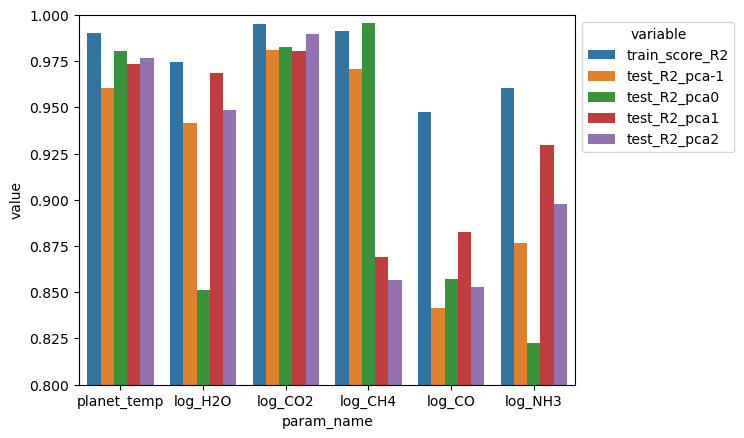

In [8]:
df_bar = pd.melt(
    totes_metriques[['param_name', 'train_score_R2', 'test_R2_pca-1', 'test_R2_pca0', 'test_R2_pca1','test_R2_pca2' ]], 
    id_vars=['param_name'], 
    value_vars=['train_score_R2', 'test_R2_pca-1', 'test_R2_pca0', 'test_R2_pca1','test_R2_pca2']
)

ax = sns.barplot(data=df_bar, x="param_name", y="value", hue="variable")
plt.ylim(0.8, 1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Comparació entre els valors predits i els esperats

### Per totes les mostres del conjunt test

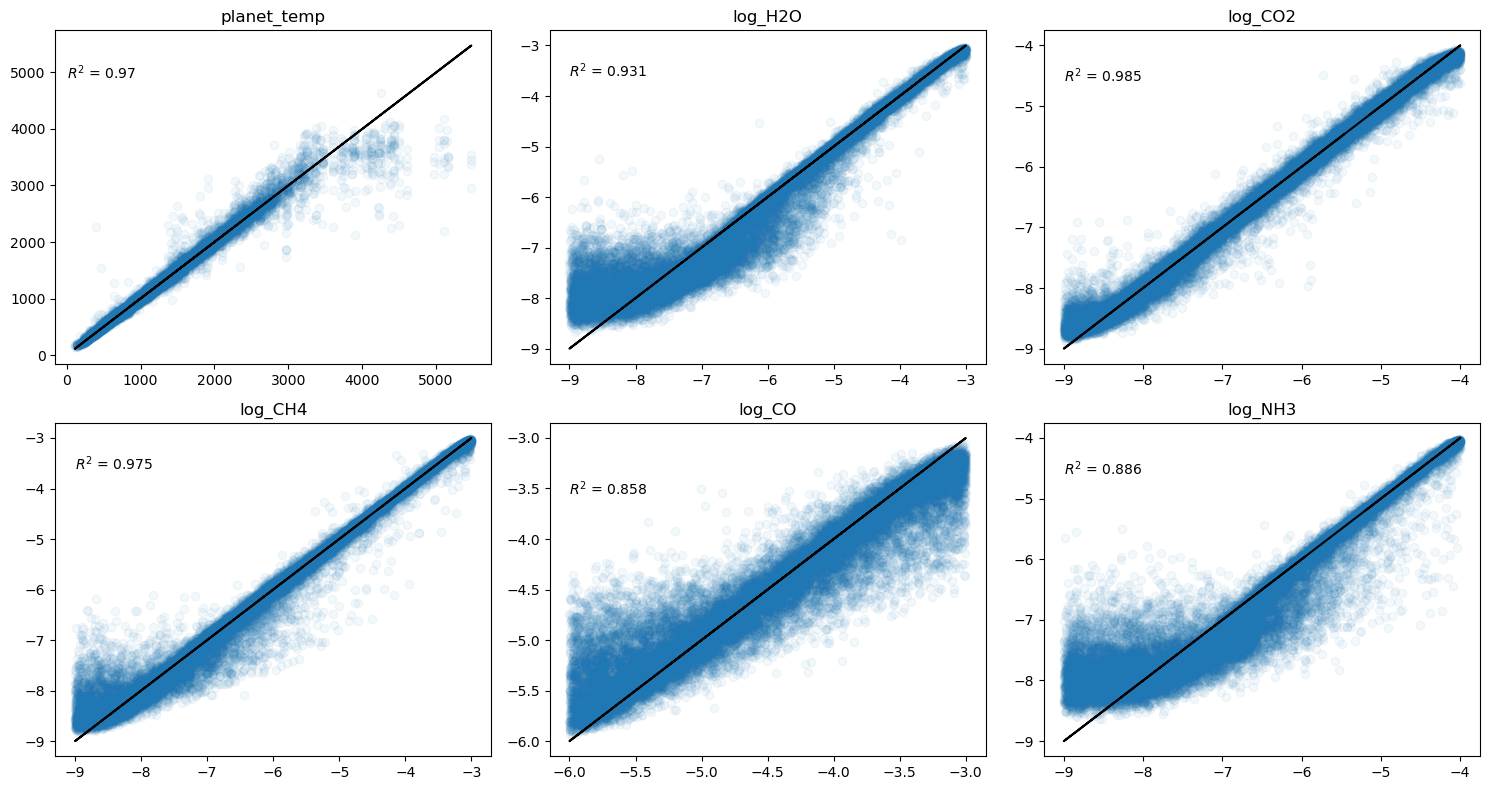

In [9]:
alpha_level = 0.05

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

x = y_test_all[:,0]; y = y_pred_df[param_names[0]]
axes[0,0].scatter(x, y, alpha = alpha_level) #, c=pca_labels_test
axes[0,0].plot(x, x,'k-')
axes[0,0].set(title = param_names[0])
R2 = r2_score(x, y)
axes[0,0].text(0, 5000, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,1]; y = y_pred_df[param_names[1]]
axes[0,1].scatter(x, y, alpha = alpha_level)
axes[0,1].plot(x, x, 'k-')
axes[0,1].set(title = param_names[1])
R2 = r2_score(x, y)
axes[0,1].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,2]; y = y_pred_df[param_names[2]]
axes[0,2].scatter(x, y, alpha = alpha_level)
axes[0,2].plot(x, x,'k-')
axes[0,2].set(title = param_names[2])
R2 = r2_score(x, y)
axes[0,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,3]; y = y_pred_df[param_names[3]]
axes[1,0].scatter(x, y, alpha = alpha_level)
axes[1,0].plot(x, x,'k-')
axes[1,0].set(title = param_names[3])
R2 = r2_score(x, y)
axes[1,0].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,4]; y = y_pred_df[param_names[4]]
axes[1,1].scatter(x, y, alpha = alpha_level)
axes[1,1].plot(x, x,'k-')
axes[1,1].set(title = param_names[4])
R2 = r2_score(x, y)
axes[1,1].text(-6, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,5]; y = y_pred_df[param_names[5]]
axes[1,2].scatter(x, y, alpha = alpha_level)
axes[1,2].plot(x, x,'k-')
axes[1,2].set(title = param_names[5])
R2 = r2_score(x, y)
axes[1,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

plt.tight_layout()
plt.show()

### Per cada grup espectral per separat

Els grups espectrals són grups d'espectres amb característiques més homoegènies, determinats amb PCA + DBSCAN.

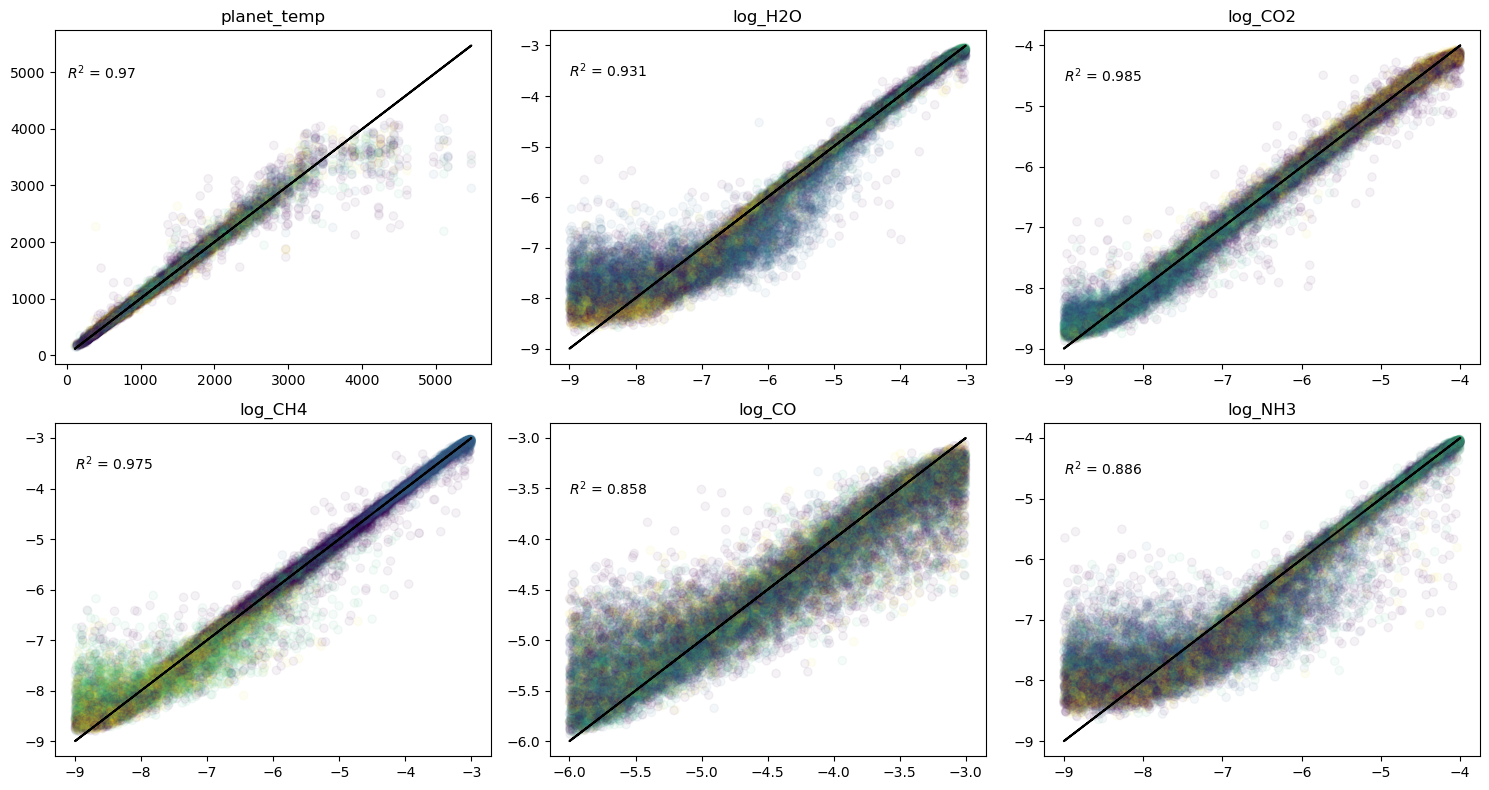

In [10]:
alpha_level = 0.05

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

x = y_test_all[:,0]; y = y_pred_df[param_names[0]]
axes[0,0].scatter(x, y, alpha = alpha_level, c=pca_labels_test) 
axes[0,0].plot(x, x,'k-')
axes[0,0].set(title = param_names[0])
R2 = r2_score(x, y)
axes[0,0].text(0, 5000, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,1]; y = y_pred_df[param_names[1]]
axes[0,1].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[0,1].plot(x, x, 'k-')
axes[0,1].set(title = param_names[1])
R2 = r2_score(x, y)
axes[0,1].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,2]; y = y_pred_df[param_names[2]]
axes[0,2].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[0,2].plot(x, x,'k-')
axes[0,2].set(title = param_names[2])
R2 = r2_score(x, y)
axes[0,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,3]; y = y_pred_df[param_names[3]]
axes[1,0].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[1,0].plot(x, x,'k-')
axes[1,0].set(title = param_names[3])
R2 = r2_score(x, y)
axes[1,0].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,4]; y = y_pred_df[param_names[4]]
axes[1,1].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[1,1].plot(x, x,'k-')
axes[1,1].set(title = param_names[4])
R2 = r2_score(x, y)
axes[1,1].text(-6, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,5]; y = y_pred_df[param_names[5]]
axes[1,2].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[1,2].plot(x, x,'k-')
axes[1,2].set(title = param_names[5])
R2 = r2_score(x, y)
axes[1,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

plt.tight_layout()
plt.show()

In [11]:
def get_y_pred(nParam):
    # Dades y_test per aquest parametre
    y_test = y_test_all[:, nParam]
    y_train = y_train_all[:, nParam]
    
    # Model d'aquest paràmetre
    model = pickle.load(open("/kaggle/working/cuRF_"+str(nParam), "rb"))
    
    # Calculem les prediccions del conjunt test
    y_pred = model.predict(X_test)
    
    return(y_pred)

In [12]:
def scatterplot_by_group(nParam):

    df = pd.DataFrame()
    df['y_pred'] = get_y_pred(nParam)
    df['y_true'] = y_test_all[:,nParam]
    df['pca_label'] = pca_labels_test

    sns.relplot(data=df, x="y_true", y="y_pred", hue="pca_label", col="pca_label", alpha=0.1)

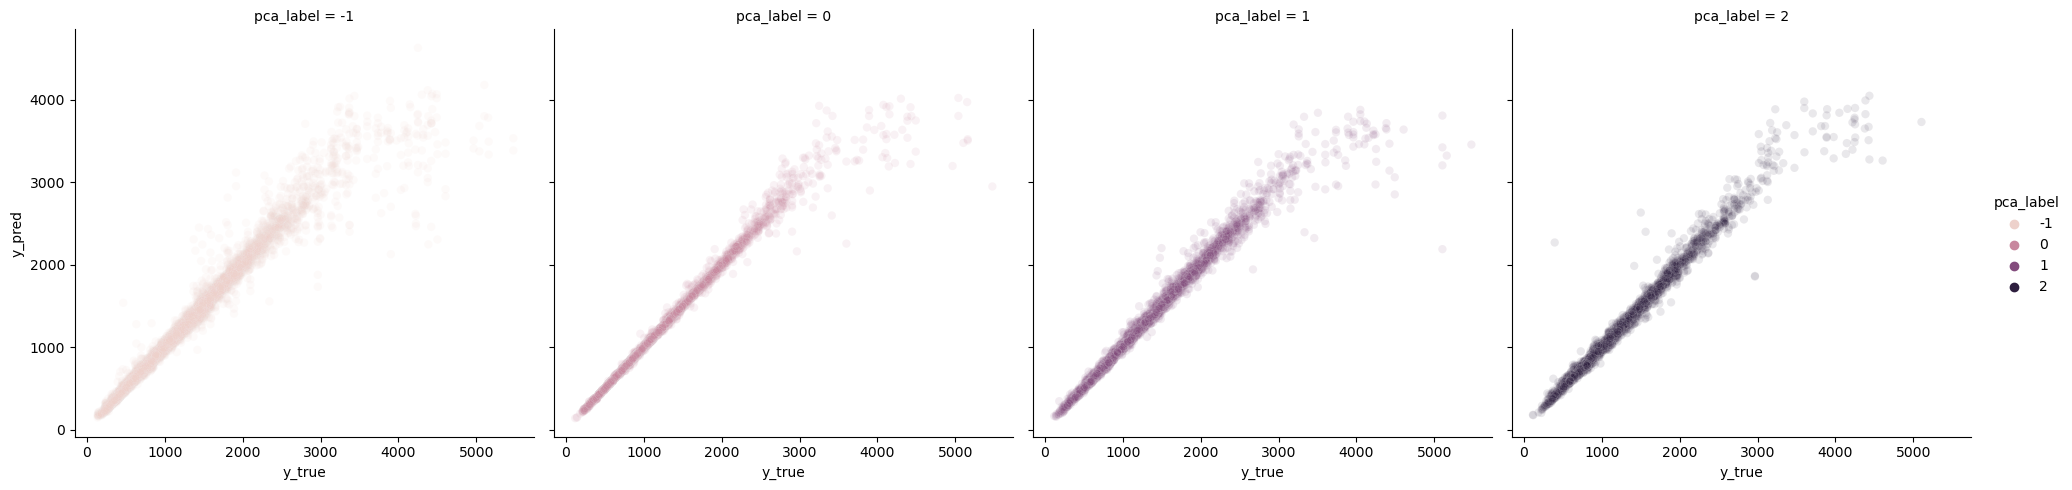

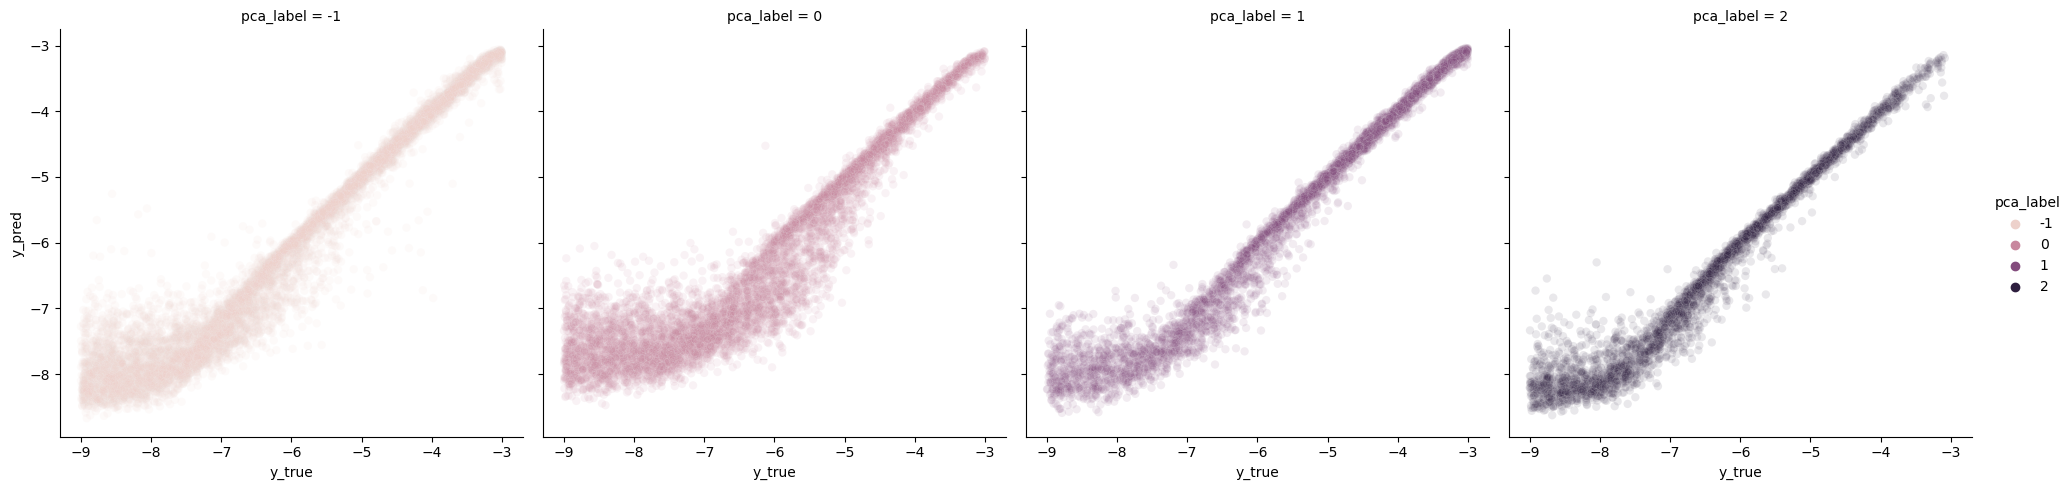

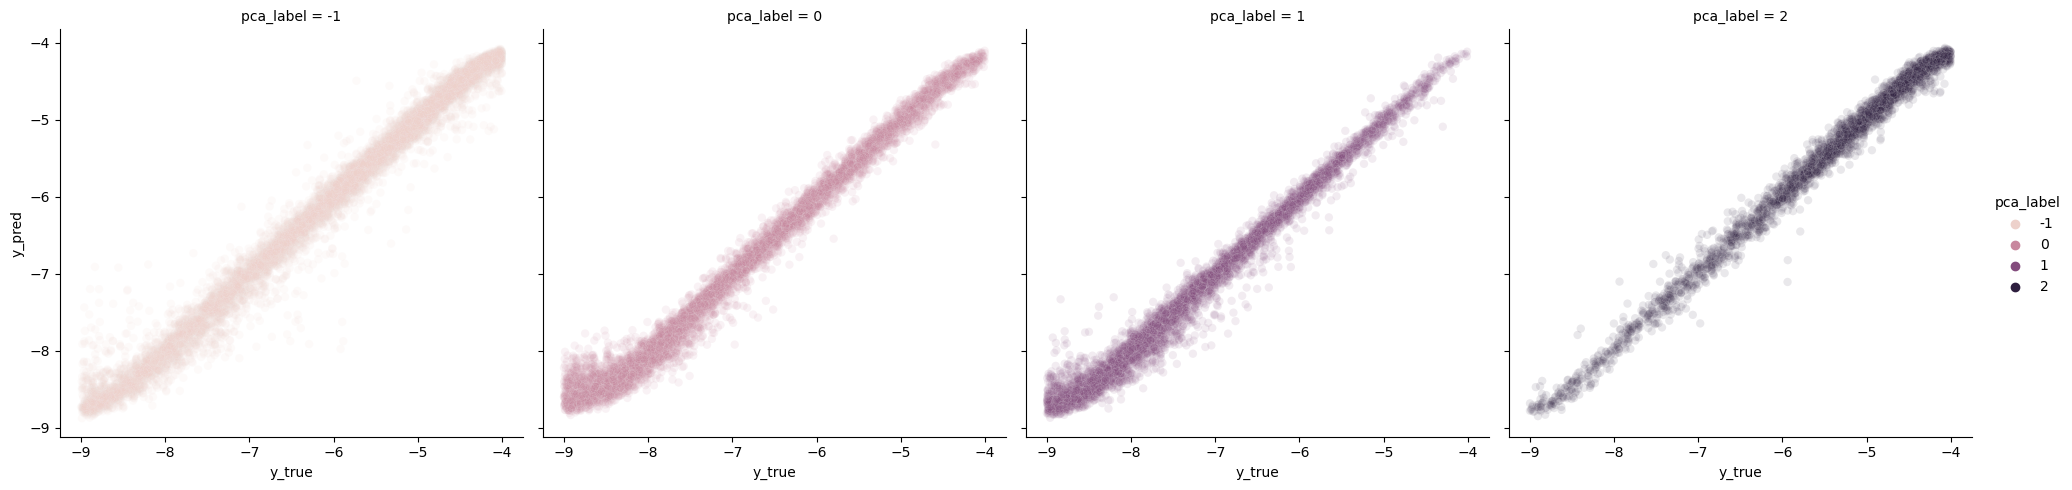

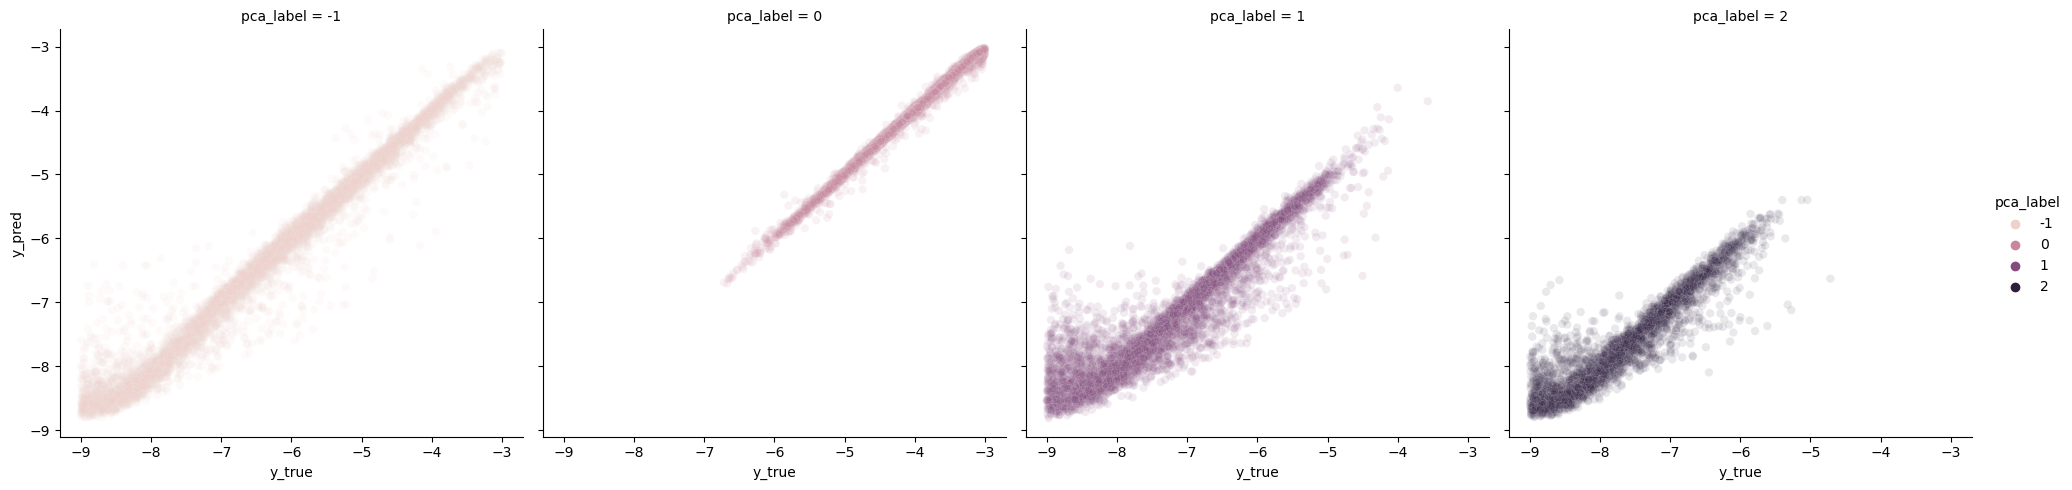

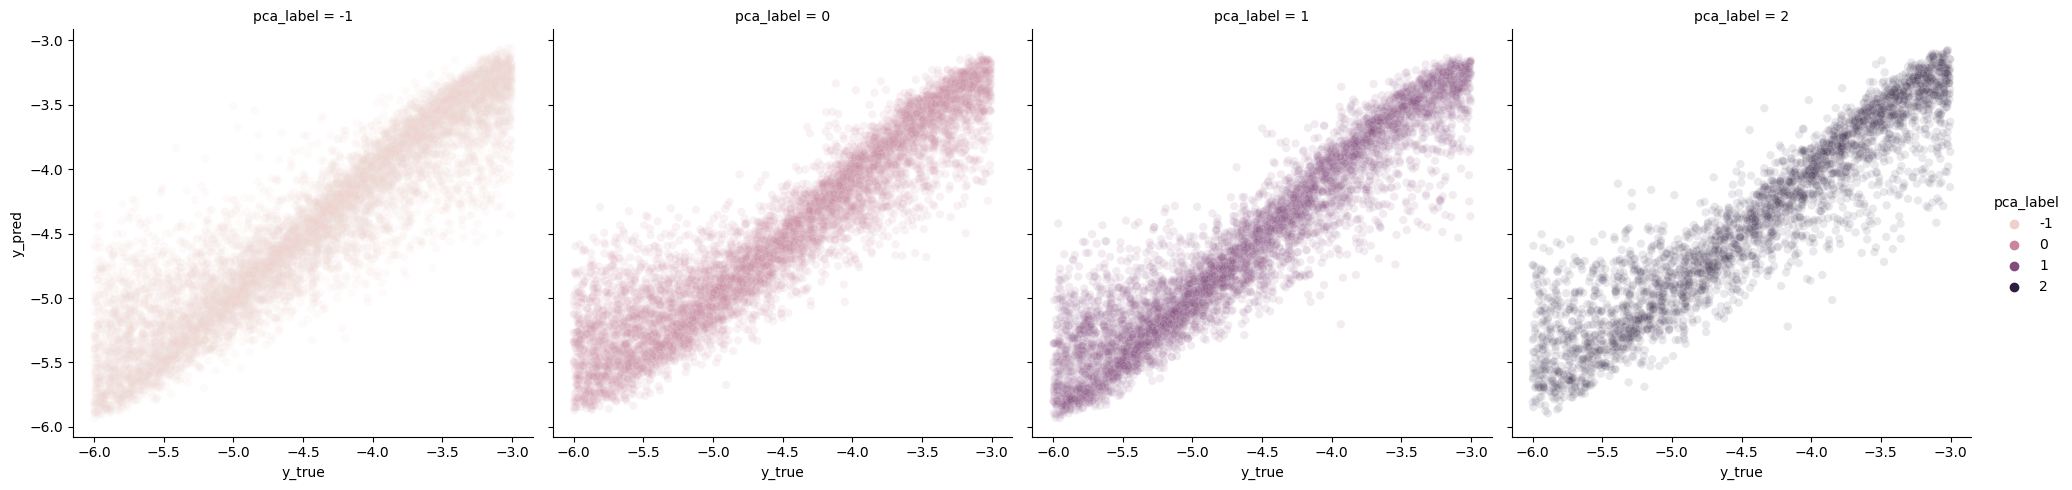

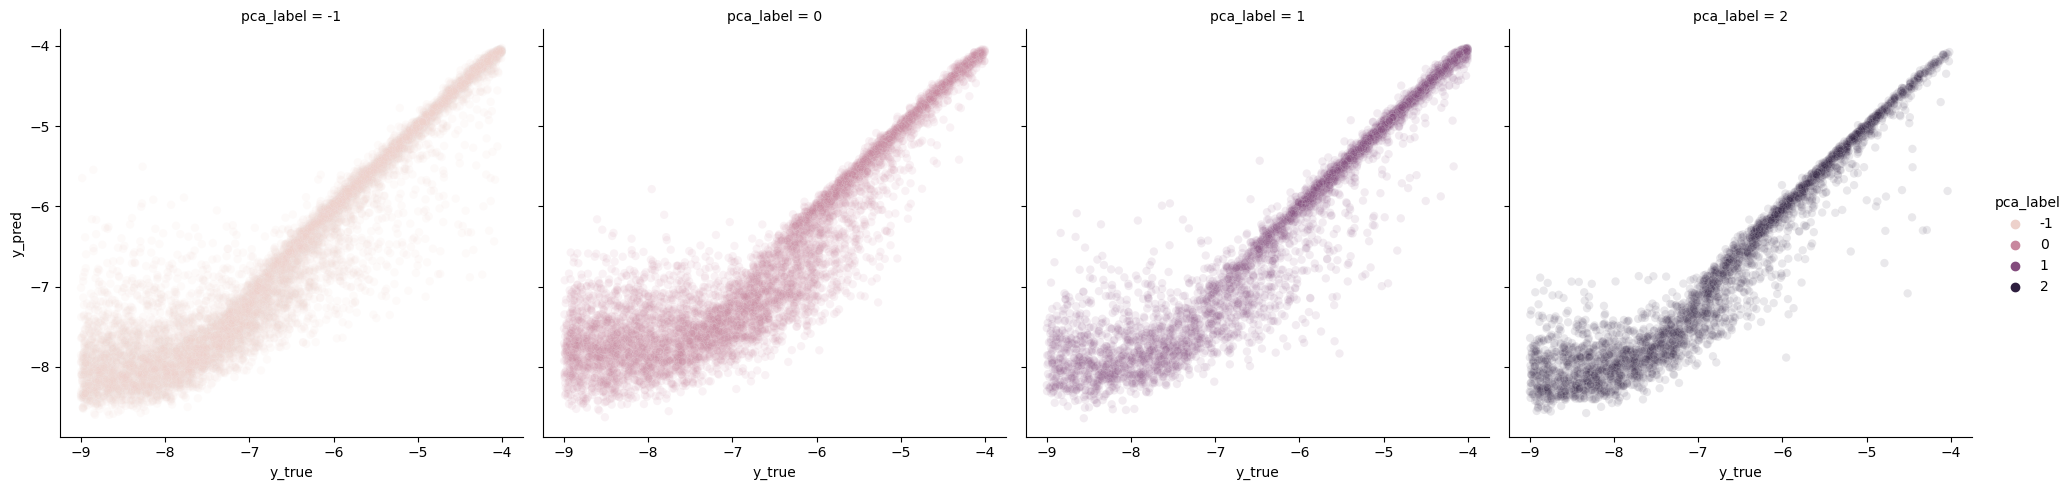

In [13]:
for i in range(0,6):
    scatterplot_by_group(i)